# Parallelization for Microscopic Image Deconvolution

### Import related packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from time import time
from numba import cuda
from skimage import color
from scipy.signal import convolve

### Define Richardson-Lucy algorithm
Code largely borrowed from skimage.restorian package, not parallelized

In [2]:
def richardson_lucy(image, psf, num_iter=50):
   """Richardson-Lucy deconvolution.

   Parameters
   ----------
   image : ndarray
      Input degraded image (can be N dimensional).
   psf : ndarray
      The point spread function.
   num_iter : int, optional
      Number of iterations. This parameter plays the role of
      regularisation.

   Returns
   -------
   im_deconv : ndarray
      The deconvolved image.

   References
   ----------
   [1] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
   [2] https://scikit-image.org/docs/stable/auto_examples/filters/plot_deconvolution.html
   """
   im_deconv = np.full(image.shape, 0.5, dtype=image.dtype)
   psf_mirror = np.flip(psf)

   # Small regularization parameter used to avoid 0 divisions
   eps = 1e-12

   for _ in range(num_iter):
      conv = convolve(im_deconv, psf, mode='same', method='direct') + eps
      relative_blur = image/conv
      im_deconv *= convolve(relative_blur, psf_mirror, mode='same', method='direct')
   
   im_deconv[im_deconv > 1] = 1
   im_deconv[im_deconv < -1] = -1

   return im_deconv

### Results and time consumed for traditional R-L deconvolution algorithm

CPU: Richardson_lucy execution time:  29.97187900543213 s


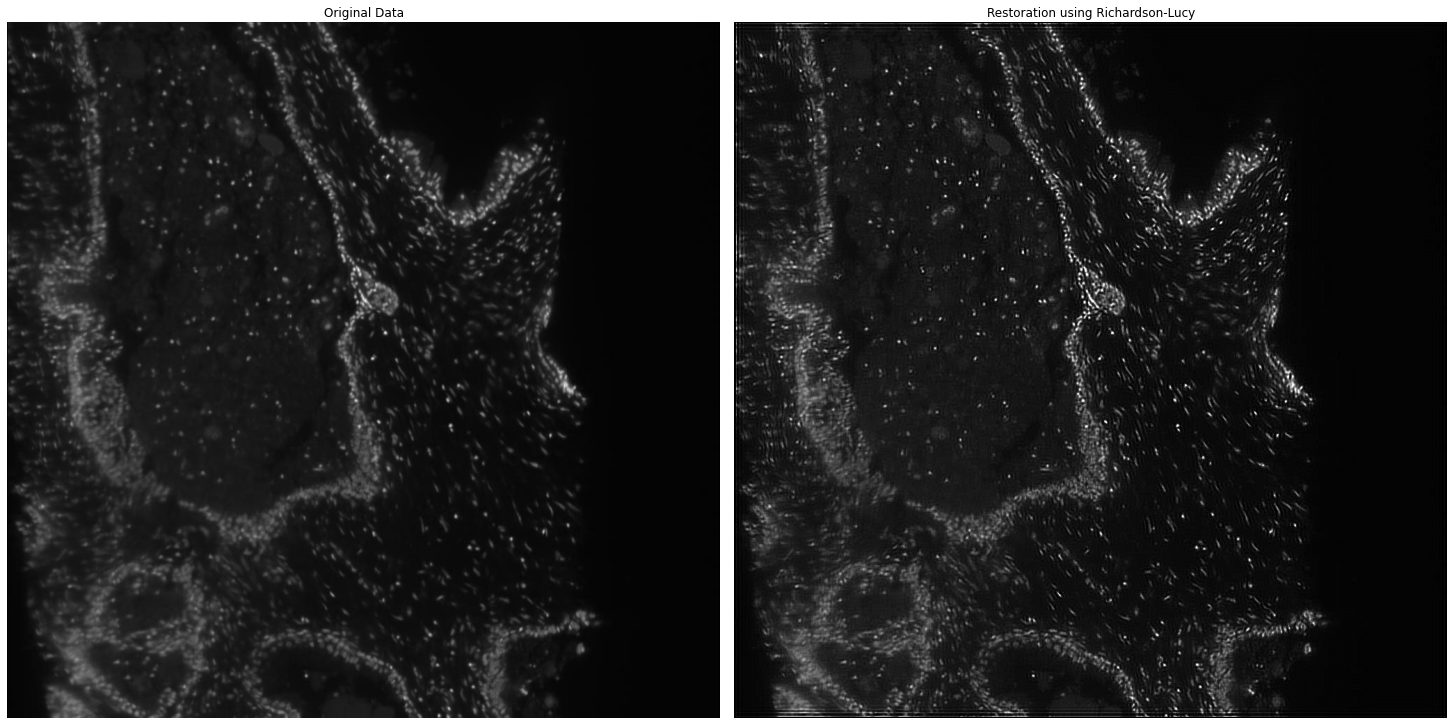

In [3]:
img = color.rgb2gray(cv2.imread('../data/test_nuclei_000004.jpg'))
psf = np.ones((5, 5))/25

# Restore Image using Richardson-Lucy algorithm
start = time()
deconvolved_RL = richardson_lucy(img, psf)
end = time()
elapsed = end - start
print("CPU: Richardson_lucy execution time: ", elapsed, "s")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
plt.gray()

for a in (ax[0], ax[1]):
       a.axis('off')

ax[0].imshow(img)
ax[0].set_title('Original Data')

ax[1].imshow(deconvolved_RL)
ax[1].set_title('Restoration using Richardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

### Parallelize the convolution part of the R-L algorithm using stencil of any size

In [4]:
img = color.rgb2gray(cv2.imread('../data/test_nuclei_000004.jpg'))
TPB = 16

@cuda.jit
def conv_kernel(d_v, d_u, d_PSF):
    """
    Compute the updated convolution array based a stencil \
    based on global memory arrays. The size of the stencil is determined by the size of the PSF matrix that is entered bt the user. 
    
    Arguments:
        d_v: 2D float device array of updated values
        d_u: 2D float device array of current values
        d_PSF: array of PSF values 
    returns:
        None
    """
    i,j = cuda.grid(2)
    dims = d_u.shape
    s_i, s_j = cuda.grid(2)
    RAD = int(PSF.shape[0]//2) #finds the radius of the PSF function
    
    if RAD <= i <= dims[0] - RAD and RAD <= j <= dims[1] - RAD: #bounds check
        sum = 0
        for s_i in range(2*RAD +1): #the nested for loop computes the 25-point stencil for any PSF matrix
            for s_j in range(2*RAD +1):
                sum += d_PSF[s_i,s_j]*d_u[i-RAD+s_i,j-RAD+s_j]
                d_v[i,j] = sum

def conv(u, iter_count, PSF, memspec='global'):
    """
    Wrapper function for computing convolution using 25-point stencil.
    
    Arguments:
        u: numpy float 2D array of current image
        iter_count: int number of update iterations
        PSF: array of PSF values 
        memspec: string; set memspec='shared' for updates based on shared memory kernel 
    Returns:
        convoluted 2D array of image
    """

    d_PSF = cuda.to_device(PSF)
    d_u = cuda.to_device(u)
    d_v = cuda.to_device(u)
    dims = u.shape
    gridDims = [(dims[0] + TPB - 1)//TPB, (dims[1] + TPB - 1)//TPB]
    blockDims = [TPB, TPB]

    for k in range(iter_count):
        conv_kernel[gridDims, blockDims](d_v, d_u, d_PSF)
        conv_kernel[gridDims, blockDims](d_u, d_v, d_PSF)

    return d_u.copy_to_host()

### Plot the image before and after the convolution

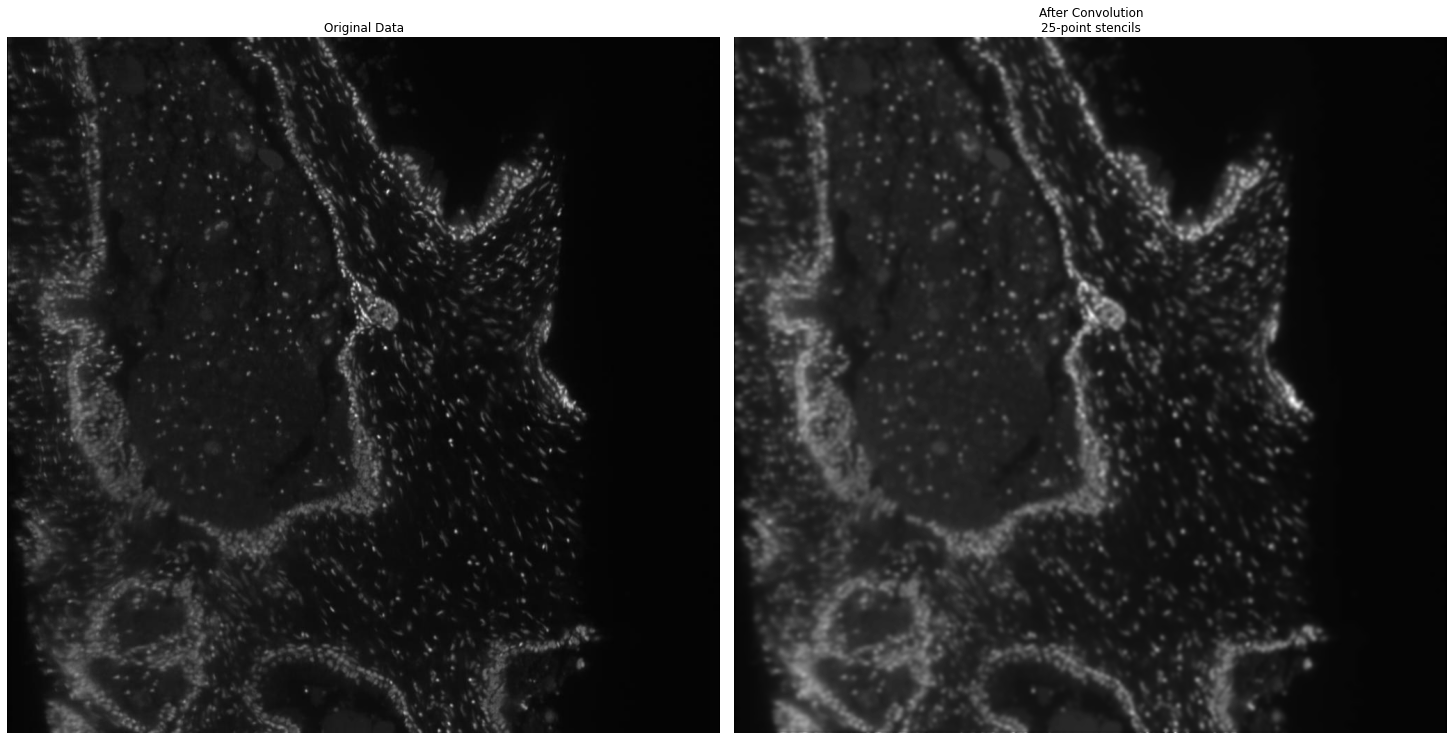

In [5]:
PSF = np.ones((5, 5))/25
convolved = conv(img, 1, PSF)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
plt.gray()
for a in (ax[0], ax[1]):
       a.axis('off')
ax[0].imshow(img)
ax[0].set_title('Original Data')
ax[1].imshow(convolved)
ax[1].set_title('After Convolution\n25-point stencils')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()


### Implement the parallelized version of R-L algorithm

In [6]:
def rl_par(image, psf, num_iter=50):
   """Richardson-Lucy deconvolution.

   Arguments:
        image : ndarray
            Input degraded image (can be N dimensional).
        psf : ndarray
            The point spread function.
        num_iter : int, optional
            Number of iterations. This parameter plays the role of
            regularisation.

   Returns:
        im_deconv : ndarray
        The deconvolved image.

   References:
   [1] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
   [2] https://scikit-image.org/docs/stable/auto_examples/filters/plot_deconvolution.html
   """

   im_deconv = np.full(image.shape, 0.5, dtype=image.dtype)
#    psf_mirror = np.flip(psf)

   # Small regularization parameter used to avoid 0 divisions
   eps = 1e-12
   for _ in range(num_iter):
    #   conv = convolve(im_deconv, psf, mode='same',method='direct') + eps
      con = conv(im_deconv, 1, psf) + eps
      relative_blur = image/con
    #   im_deconv *= convolve(relative_blur, psf_mirror, mode='same',method='direct')
      con = conv(relative_blur, 1, psf) #
      im_deconv *= con

      
   im_deconv[im_deconv > 1] = 1
   im_deconv[im_deconv < -1] = -1

   return im_deconv

### Experiment of the parallelized deconvolution algorithm and time consumed

In [7]:
psf = np.ones((5, 5))/25
start = time()
deconvolved_RL_v1 = rl_par(img, psf)
end = time()
elapsed_par = end - start
print("Global GPU: Richardson_lucy execution time: ", elapsed_par, "s")
print("Speedup factor: ", elapsed/elapsed_par)
device = cuda.get_current_device()
print(device)


Global GPU: Richardson_lucy execution time:  1.1162240505218506 s
Speedup factor:  26.851131716271343
<CUDA device 0 'b'Quadro P6000''>


### Plot the processed images

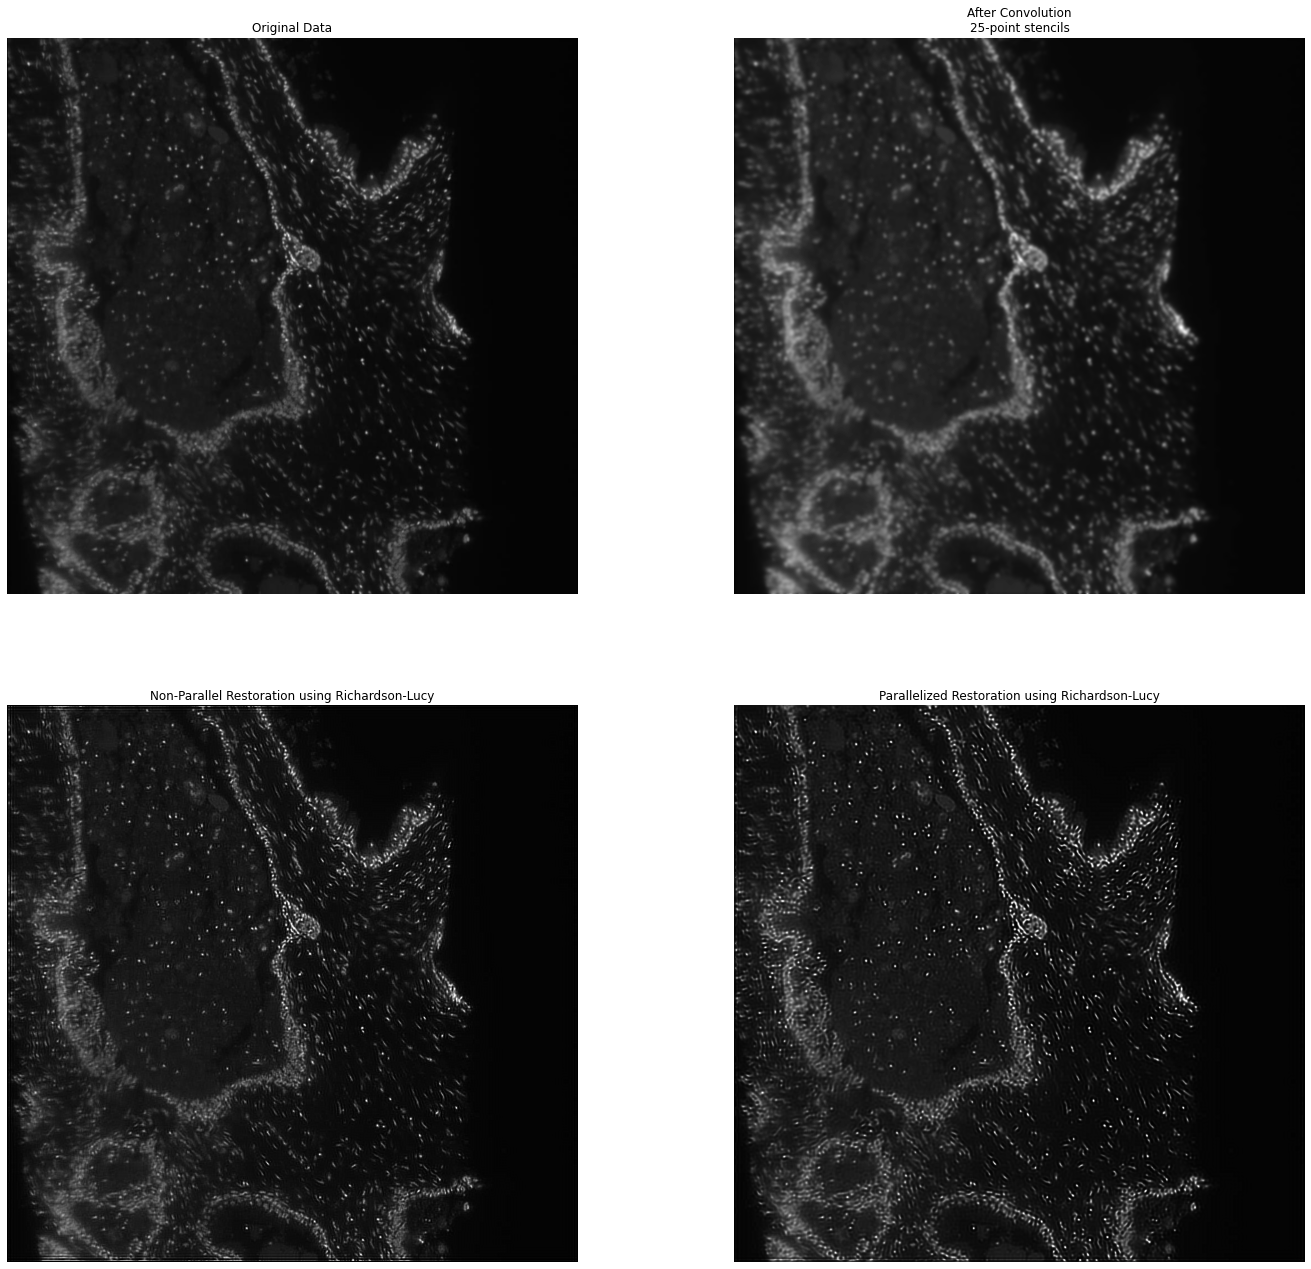

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
plt.gray()

for a in (ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]):
       a.axis('off')

ax[0, 0].imshow(img)
ax[0, 0].set_title('Original Data')

ax[0, 1].imshow(convolved)
ax[0, 1].set_title('After Convolution\n25-point stencils')

ax[1, 0].imshow(deconvolved_RL)
ax[1, 0].set_title('Non-Parallel Restoration using Richardson-Lucy')

ax[1, 1].imshow(deconvolved_RL_v1)
ax[1, 1].set_title('Parallelized Restoration using Richardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()


### Comparison for batch processing

In [9]:
import os
filelist = os.listdir("../data/")

start = time()
for i in filelist:
    img = color.rgb2gray(cv2.imread('../data/' + i))
    deconvolved_RL = richardson_lucy(img, psf)
end = time()
elapsed_cpu = end - start
print("CPU: Richardson_lucy execution time for batch images: ", elapsed_cpu, "s")

start = time()
for i in filelist:
    print('Processing', i)
    img = color.rgb2gray(cv2.imread('../data/' + i))
    deconvolved_RL_par = rl_par(img, psf)
end = time()
elapsed_gpu = end - start
print("Global GPU: Richardson_lucy execution time for batch images: ", elapsed_gpu, "s")
print("Speedup factor: ", elapsed_cpu/elapsed_gpu)


CPU: Richardson_lucy execution time for batch images:  1020.7707662582397 s
Processing 60 um eosin 1.PNG
Processing 60 um topro 2.PNG
Processing cycle eosin 4.PNG
Processing rl_parallel_compare.png
Processing topro.PNG
Processing test_nuclei_000002.jpg
Processing test_nuclei_000000.jpg
Processing test_nuclei_000001_deconv.jpg
Processing Mol5.PNG
Processing test_nuclei_000001.jpg
Processing topro_decon.PNG
Processing test_nuclei_000004_decon.jpg
Processing test_nuclei_000004.jpg
Processing test_nuclei_000003.jpg
Processing test_nuclei_000004_decon_v1.jpg
Processing mol5_deconv.png
Processing 1000_1500_grayscale_2022-05-09T12-57-31.394.tif
Processing 60 um eosin 3.PNG
Processing cycle topro 3.PNG
Global GPU: Richardson_lucy execution time for batch images:  36.306828022003174 s
Speedup factor:  28.11511833640818
